<a href="https://colab.research.google.com/github/BecomeAllan/ML-SLRC/blob/main/Meta_learning_EFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook was used to conduct a research of a agnostic-model for systematics literatures reviews classification, using [Entailment as Few-shot classification](https://arxiv.org/abs/2104.14690) and [first-order meta-learning algorithms](https://arxiv.org/abs/1803.02999) with a pre-trained language model [SciBERT](https://arxiv.org/abs/1903.10676).

The etailment text used was "It is a great text.".

## Requirements

In [1]:
!pip install transformers==4.16.2
!pip install torchmetrics==0.8.0

!pip install matplotlib==3.5.1

In [2]:
%matplotlib inline
import torch.nn.functional as F
import torch.nn as nn
import math
import torch
import numpy as np
import pandas as pd
import time
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.manifold import TSNE
from copy import deepcopy, copy
import seaborn as sns
import matplotlib.pylab as plt
from pprint import pprint
import shutil
import datetime
import re
import json
from pathlib import Path

SEED = 2222

gen_seed = torch.Generator().manual_seed(SEED)

# Useful Functions

Useful function to conduct the research

## Random


In [3]:
import random

# Random seed function
def random_seed(value):
    torch.backends.cudnn.deterministic=True
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    np.random.seed(value)
    random.seed(value)

# Tasks for meta-learner
def create_batch_of_tasks(taskset, is_shuffle = True, batch_size = 4):
    idxs = list(range(0,len(taskset)))
    if is_shuffle:
        random.shuffle(idxs)
    for i in range(0,len(idxs), batch_size):
        yield [taskset[idxs[i]] for i in range(i, min(i + batch_size,len(taskset)))]


## Diagnosis

### Framework

In [4]:
# Prepare data to process by Domain-learner
def prepare_data(data, batch_size, tokenizer,max_seq_length,
                 input = 'text', output = 'label',
                 train_size_per_class = 5, global_datasets = False):
  data = data.reset_index().drop("index", axis=1)

  if global_datasets:
    global data_train, data_test

  # Sample task for training
  data_train = data.groupby('label').sample(train_size_per_class, replace=False)
  idex = data.index.isin(data_train.index)

  # The Test set to label by the model
  data_test = data[~idex].reset_index()


  # Transform in dataset to model
  ## Train
  dataset_train = SLR_DataSet(
    data = data_train.sample(frac=1),
    input = input,
    output = output,
    tokenizer=tokenizer,
    max_seq_length =max_seq_length)

  ## Test
  dataset_test = SLR_DataSet(
    data = data_test,
    input = input,
    output = output,
    tokenizer=tokenizer,
    max_seq_length =max_seq_length)
  
  # Dataloaders
  ## Train 
  data_train_loader = DataLoader(dataset_train,
                           shuffle=True,
                           batch_size=batch_size['train']
                                )
  
  ## Test
  if len(dataset_test) % batch_size['test'] == 1 :
    data_test_loader = DataLoader(dataset_test,
                                    batch_size=batch_size['test'],
                                    drop_last=True)
  else:
    data_test_loader = DataLoader(dataset_test,
                                    batch_size=batch_size['test'],
                                    drop_last=False)

  return data_train_loader, data_test_loader, data_train, data_test


In [5]:
from tqdm import tqdm

# Meta trainer
def meta_train(data, model, device, Info, print_epoch =True, size_layer=0, Test_resource =None):

  # Meta-learner model
  learner = Learner(model = model, device = device, **Info)
  
  # Testing tasks
  if isinstance(Test_resource, pd.DataFrame):
    test = MetaTask(Test_resource, num_task = 0, k_support=10, k_query=10,
                  training=False, **Info)


  torch.clear_autocast_cache()
  gc.collect()
  torch.cuda.empty_cache()

  # Meta epoch (Outer epoch)
  for epoch in tqdm(range(Info['meta_epoch']), desc= "Meta epoch ", ncols=80):
      
      # Train tasks
      train = MetaTask(data,
                      num_task = Info['num_task_train'],
                      k_support=Info['k_qry'],
                      k_query=Info['k_spt'], **Info)

      # Batch of train tasks
      db = create_batch_of_tasks(train, is_shuffle = True, batch_size = Info["outer_batch_size"])

      if print_epoch:
      # Outer loop bach training
        for step, task_batch in enumerate(db):          
            print("\n-----------------Training Mode","Meta_epoch:", epoch ,"-----------------\n")
            
            # meta-feedfoward (outer-feedfoward)
            acc = learner(task_batch, valid_train= print_epoch)
            print('Step:', step, '\ttraining Acc:', acc)
        
        if isinstance(Test_resource, pd.DataFrame):
          # Validating Model
          if ((epoch+1) % 4) + step == 0:
              random_seed(123)
              print("\n-----------------Testing Mode-----------------\n")
              
              # Batch of test tasks
              db_test = create_batch_of_tasks(test, is_shuffle = False, batch_size = 1)
              acc_all_test = []

              # Looping testing tasks
              for test_batch in db_test:
                  acc = learner(test_batch, training = False)
                  acc_all_test.append(acc)

              print('Test acc:', np.mean(acc_all_test))
              del acc_all_test, db_test

              # Restarting training randomly
              random_seed(int(time.time() % 10))

      else:
        for step, task_batch in enumerate(db):
            # meta-feedfoward (outer-feedfoward)
            acc = learner(task_batch, print_epoch, valid_train= print_epoch)

  torch.clear_autocast_cache()
  gc.collect()
  torch.cuda.empty_cache()

In [6]:
def train_loop(data_train_loader, data_test_loader, model, device, epoch = 4, lr = 1, print_info = True, name = 'name'):
  # Start the model's parameters
  model_meta = deepcopy(model)
  optimizer = Adam(model_meta.parameters(), lr=lr)

  model_meta.to(device)
  model_meta.train()

  # Task epoch (Inner epoch)
  for i in range(0, epoch):
      all_loss = []

      # Inner training batch (support set)
      for inner_step, batch in enumerate(data_train_loader):
          batch = tuple(t.to(device) for t in batch)
          input_ids, attention_mask,q_token_type_ids, label_id = batch
          
          # Inner Feedfoward
          loss, _, _ = model_meta(input_ids, attention_mask,q_token_type_ids, labels = label_id.squeeze())
          
          # compute grads
          loss.backward()

          # update parameters
          optimizer.step()
          optimizer.zero_grad()
          
          all_loss.append(loss.item())
      

      if (i % 2 == 0) & print_info:
          print("Loss: ", np.mean(all_loss))


  # Test evaluation
  model_meta.eval()
  all_loss = []
  all_acc = []
  features = []
  labels = []
  predi_logit = []

  with torch.no_grad():
      # Test's Batch loop
      for inner_step, batch in enumerate(tqdm(data_test_loader,
                                              desc="Test validation | " + name,
                                              ncols=80)) :
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask,q_token_type_ids, label_id = batch

        # Predictions
        _, feature, prediction = model_meta(input_ids, attention_mask,q_token_type_ids, labels = label_id.squeeze())

        # Save batch's predictions 
        prediction = prediction.detach().cpu().squeeze()
        label_id = label_id.detach().cpu()
        labels.append(label_id.numpy().squeeze())
        
        logit = feature[1].detach().cpu()
        predi_logit.append(logit.numpy())

        feature_lat = feature[0].detach().cpu()
        features.append(feature_lat.numpy())

        # Accuracy over the test's bach
        acc = fn.accuracy(prediction, label_id).item()
        all_acc.append(acc)
      del input_ids, attention_mask, label_id, batch

  if print_info:
    print("acc:", np.mean(all_acc))

  model_meta.to('cpu')
  gc.collect()
  torch.cuda.empty_cache()

  del model_meta, optimizer

  return map_feature_tsne(features, labels, predi_logit)

# Process predictions and map the feature_map in tsne
def map_feature_tsne(features, labels, predi_logit):
  
  features = np.concatenate(np.array(features,dtype=object))
  features = torch.tensor(features.astype(np.float32)).detach().clone()
  
  labels = np.concatenate(np.array(labels,dtype=object))
  labels = torch.tensor(labels.astype(int)).detach().clone()

  logits = np.concatenate(np.array(predi_logit,dtype=object))
  logits = torch.tensor(logits.astype(np.float32)).detach().clone()

  # Dimention reduction
  X_embedded = TSNE(n_components=2, learning_rate='auto',
                    init='random').fit_transform(features.detach().clone())

  return logits.detach().clone(), X_embedded, labels.detach().clone(), features.detach().clone()
  


In [7]:
def wss_calc(logit, labels, trsh = 0.5):
  
  # Prediction label given the treshould
  predict_trash = torch.sigmoid(logit).squeeze() >= trsh
  
  # Compute confusion matrix values
  CM = confusion_matrix(labels, predict_trash.to(int) )
  tn, fp, fne, tp = CM.ravel()

  P = (tp + fne)  
  N = (tn + fp) 
  recall = tp/(tp+fne)

  # WSS
  wss = (tn + fne)/len(labels) -(1- recall)

  # AWSS
  awss = (tn/N - fne/P)

  return {
      "wss": round(wss,4),
      "awss": round(awss,4),
      "R": round(recall,4),
      "CM": CM
      }

In [8]:
from sklearn.metrics import confusion_matrix
from torchmetrics import functional as fn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import ipywidgets as widgets
from IPython.display import HTML, display, clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Compute the metrics
def plot(logits, X_embedded, labels, tresh, show = True,
         namefig = "plot", make_plot = True, print_stats = True, save = True):
  col = pd.MultiIndex.from_tuples([
                                   ("Predict", "0"),
                                   ("Predict", "1")
                                   ])
  index = pd.MultiIndex.from_tuples([
                                   ("Real", "0"),
                                   ("Real", "1")
                                   ])

  predict = torch.sigmoid(logits).detach().clone()

  # Roc curve
  fpr, tpr, thresholds = roc_curve(labels, predict.squeeze())

  # Given by a Recall of 95% (treshould avaliation)
  ## WSS
  ### Index to recall
  idx_wss95 = sum(tpr < 0.95)
  ### Treshould
  thresholds95 = thresholds[idx_wss95]

  ### Compute the metrics
  wss95_info = wss_calc(logits,labels, thresholds95 )
  acc_wss95 = fn.accuracy(predict, labels, threshold=thresholds95)
  f1_wss95 = fn.f1_score(predict, labels, threshold=thresholds95)


  # Given by a treshould (recall avaliation)
  ### Compute the metrics
  wss_info = wss_calc(logits,labels, tresh )
  acc_wssR = fn.accuracy(predict, labels, threshold=tresh)
  f1_wssR = fn.f1_score(predict, labels, threshold=tresh)


  metrics= {
      # WSS
      "WSS@95": wss95_info['wss'],
      "AWSS@95": wss95_info['awss'],
      "WSS@R": wss_info['wss'],
      "AWSS@R": wss_info['awss'],
      # Recall
      "Recall_WSS@95": wss95_info['R'],
      "Recall_WSS@R": wss_info['R'],
      # acc
      "acc@95": acc_wss95.item(),
      "acc@R": acc_wssR.item(),
      # f1
      "f1@95": f1_wss95.item(),
      "f1@R": f1_wssR.item(),
      # treshould 95
      "treshould@95": thresholds95
  }

  # Print stats
  if print_stats:
    wss95= f"WSS@95:{wss95_info['wss']}, R: {wss95_info['R']}"
    wss95_adj= f"ASSWSS@95:{wss95_info['awss']}"
    print(wss95)
    print(wss95_adj)
    print('Acc.:', round(acc_wss95.item(), 4))
    print('F1-score:', round(f1_wss95.item(), 4))
    print(f"Treshold to wss95: {round(thresholds95, 4)}")
    cm = pd.DataFrame(wss95_info['CM'],
              index=index,
              columns=col)
    
    print("\nConfusion matrix:")
    print(cm)
    print("\n---Metrics with threshold:", tresh, "----\n")
    wss= f"WSS@R:{wss_info['wss']}, R: {wss_info['R']}"
    print(wss)
    wss_adj= f"AWSS@R:{wss_info['awss']}"
    print(wss_adj)
    print('Acc.:', round(acc_wssR.item(), 4))
    print('F1-score:', round(f1_wssR.item(), 4))
    cm = pd.DataFrame(wss_info['CM'],
                index=index,
                columns=col)
      
    print("\nConfusion matrix:")
    print(cm)


  # Plots

  if make_plot:

    fig, axes = plt.subplots(1, 4, figsize=(25,10))
    alpha = torch.squeeze(predict).numpy()

    # TSNE
    p1 = sns.scatterplot(x=X_embedded[:, 0],
                  y=X_embedded[:, 1],
                  hue=labels,
                  alpha=alpha, ax = axes[0]).set_title('Predictions-TSNE')
    
    
    # WSS@95
    t_wss = predict >= thresholds95
    t_wss = t_wss.squeeze().numpy()
    p2 = sns.scatterplot(x=X_embedded[t_wss, 0],
                  y=X_embedded[t_wss, 1],
                  hue=labels[t_wss],
                  alpha=alpha[t_wss], ax = axes[1]).set_title('WSS@95')

    # WSS@R
    t = predict >= tresh
    t = t.squeeze().numpy()
    p3 = sns.scatterplot(x=X_embedded[t, 0],
                  y=X_embedded[t, 1],
                  hue=labels[t],
                  alpha=alpha[t], ax = axes[2]).set_title(f'Predictions-Treshold {tresh}')

    # ROC-Curve
    roc_auc = auc(fpr, tpr)
    lw = 2
    axes[3].plot(
      fpr,
      tpr,
      color="darkorange",
      lw=lw,
      label="ROC curve (area = %0.2f)" % roc_auc)
    axes[3].plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    axes[3].axhline(y=0.95, color='r', linestyle='-')
    axes[3].set(xlabel="False Positive Rate", ylabel="True Positive Rate", title= "ROC")
    axes[3].legend(loc="lower right")

    if show:
      plt.show()
    
    if save:
      fig.savefig(namefig, dpi=fig.dpi)

  return metrics

def auc_plot(logits,labels, color = "darkorange", label = "test"):
    predict = torch.sigmoid(logits).detach().clone()
    fpr, tpr, thresholds = roc_curve(labels, predict.squeeze())
    roc_auc = auc(fpr, tpr)
    lw = 2

    label = label + str(round(roc_auc,2))
    # print(label)

    plt.plot(
      fpr,
      tpr,
      color=color,
      lw=lw,
      label= label 
      )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.axhline(y=0.95, color='r', linestyle='-')

### Visual exploration

In [9]:
from sklearn.metrics import confusion_matrix
from torchmetrics import functional as fn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import ipywidgets as widgets
from IPython.display import HTML, display, clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Interface to evaluation
class diagnosis():
  def __init__(self, names, Valid_resource, batch_size_test, model,Info,start = 0):
    self.names=names
    self.Valid_resource=Valid_resource
    self.batch_size_test=batch_size_test
    self.model=model
    self.start=start 

    # BOX INPUT
    self.value_trash = widgets.FloatText(
        value=0.95,
        description='tresh',
        disabled=False
    )
    self.valueb = widgets.IntText(
        value=10,
        description='size',
        disabled=False
    )

    # Buttons
    self.train_b = widgets.Button(description="Train")
    self.next_b = widgets.Button(description="Next")
    self.eval_b = widgets.Button(description="Evaluation")

    self.hbox = widgets.HBox([self.train_b, self.valueb])

    # Click buttons functions
    self.next_b.on_click(self.Next_button)
    self.train_b.on_click(self.Train_button)
    self.eval_b.on_click(self.Evaluation_button)


  # Next button
  def Next_button(self,p):
    clear_output()
    self.i=self.i+1

    # Select the domain data
    self.domain = names[self.i]
    self.data = self.Valid_resource[self.Valid_resource['domain'] == self.domain]
    
    print("Name:", self.domain)
    print(self.data['label'].value_counts())
    display(self.hbox)
    display(self.next_b)


  # Train button
  def Train_button(self, y):
    clear_output()
    print(self.domain)

    # Prepare data for training (domain-learner)
    self.data_train_loader, self.data_test_loader, self.data_train, self.data_test = prepare_data(self.data,
              train_size_per_class = self.valueb.value,
              batch_size = {'train': Info['inner_batch_size'],
                            'test': batch_size_test},
              max_seq_length = Info['max_seq_length'],
              tokenizer = Info['tokenizer'],
              input = "text",
              output = "label")

    # Train the model and predict in the test set
    self.logits, self.X_embedded, self.labels, self.features = train_loop(self.data_train_loader, self.data_test_loader,
                                                        model, device,
                                                        epoch = Info['inner_update_step'],
                                                        lr=Info['inner_update_lr'],
                                                        print_info=True,
                                                        name = self.domain)

    tresh_box = widgets.HBox([self.eval_b, self.value_trash])
    display(self.hbox)
    display(tresh_box)
    display(self.next_b)


  # Evaluation button
  def Evaluation_button(self, te):
    clear_output()
    tresh_box = widgets.HBox([self.eval_b, self.value_trash])

    print(self.domain)
    # print("\n")
    print("-------Train data-------")
    print(data_train['label'].value_counts())
    print("-------Test data-------")
    print(data_test['label'].value_counts())
    # print("\n")
    
    display(self.next_b)
    display(tresh_box)
    display(self.hbox)

    # Compute metrics    
    metrics = plot(self.logits, self.X_embedded, self.labels,
                    tresh=Info['tresh'], show = True,
                    # namefig= "./"+base_path +"/"+"Results/size_layer/"+ name_domain+'/' +str(n_layers) + '/img/' + str(attempt) + 'plots',
                    namefig= 'test',
                  make_plot = True,
                  print_stats = True,
                  save=False)

  def __call__(self):
    self.i= self.start-1
    clear_output()
    display(self.next_b)

## Simulation attemps

In [10]:
from collections import defaultdict

# Simulation attemps of domain learner
def pipeline_simulation(Valid_resource, names_to_valid, path_save, model, Info):
  n_attempt  = 5
  batch_test = 100

  # Create a directory to save informations
  for name in names_to_valid:
    name = re.sub("\.csv", "",name)
    Path(path_save  + name + "/img").mkdir(parents=True, exist_ok=True)

  # Dict to sabe roc curves
  roc_stats = defaultdict(lambda: defaultdict(
      lambda: defaultdict(
          list
          )
      )
  )


  

  all_metrics = []
  # Loop over a list of domains
  for name in names_to_valid:
    
    # Select a domain dataset
    data = Valid_resource[Valid_resource['domain'] == name].reset_index().drop("index", axis=1)

    # Attempts simulation
    for attempt in range(n_attempt):
      print("---"*4,"attempt", attempt, "---"*4)
      
      # Prepare data to pass to the model
      data_train_loader, data_test_loader,  _ , _ = prepare_data(data,
                train_size_per_class = Info['k_spt'],
                batch_size = {'train': Info['inner_batch_size'],
                              'test': batch_test},
                max_seq_length = Info['max_seq_length'],
                tokenizer = Info['tokenizer'],
                input = "text",
                output = "label")

      # Train the model and evaluate on the test set of the domain
      logits, X_embedded, labels, features = train_loop(data_train_loader, data_test_loader,
                                                        model, device,
                                                        epoch = Info['inner_update_step'],
                                                        lr=Info['inner_update_lr'],
                                                        print_info=False,
                                                        name = name)
      
      
      name_domain = re.sub("\.csv", "",name)

      # Compute the metrics
      metrics = plot(logits, X_embedded, labels,
                    tresh=Info['tresh'], show = False,
                    namefig= path_save  + name_domain + "/img/" + str(attempt) + 'plots',
        make_plot = True, print_stats = False, save =  True)

      # Compute the roc-curve
      fpr, tpr, _ = roc_curve(labels, torch.sigmoid(logits).squeeze())
      
      # Save the correspoud information of the domain
      metrics['name'] = name_domain
      metrics['layer_size'] = Info['bert_layers']
      metrics['attempt'] = attempt
      roc_stats[name_domain][str(Info['bert_layers'])]['fpr'].append(fpr.tolist())
      roc_stats[name_domain][str(Info['bert_layers'])]['tpr'].append(tpr.tolist())
      all_metrics.append(metrics)

      # Save the metrics and the roc curve  of the attemp
      pd.DataFrame(all_metrics).to_csv(path_save+ "metrics.csv")
      roc_path =  path_save + "roc_stats.json"
      with open(roc_path, 'w') as fp:
          json.dump(roc_stats, fp)


      del fpr, tpr, logits, X_embedded, labels
      del features, metrics,  _


  # Save the information used to evaluate the validation resource
  save_info = Info.copy()
  save_info['model'] = initializer_model.tokenizer.name_or_path
  save_info.pop("tokenizer")
  save_info.pop("bert_layers")

  info_path =  path_save+"info.json"
  with open(info_path, 'w') as fp:
      json.dump(save_info, fp)

## Statistics

In [11]:
# Loading dataset statistics
def load_data_statistics(paths):
  size = []
  pos = []
  neg = []
  for p in paths:
    data = pd.read_csv(p) 
    data = data.dropna()
    # Dataset size
    size.append(len(data))
    # Number of positive labels
    pos.append(data['labels'].value_counts()[1])
    # Number of negative labels
    neg.append(data['labels'].value_counts()[0])
  del data

  info_load = pd.DataFrame({
      "size":size,
      "pos":pos,
      "neg":neg,
      "names":names,
      "paths": paths })
  return info_load

# Loading the datasets
def load_data(train_info_load):

  col = ['abstract','title', 'labels', 'domain']

  data_train = pd.DataFrame(columns=col)
  for p in train_info_load['paths']:  
    data_temp = pd.read_csv(p).loc[:, ['labels', 'title', 'abstract']]
    data_temp = pd.read_csv(p).loc[:, ['labels', 'title', 'abstract']]
    data_temp['domain'] = os.path.basename(p)
    data_train = pd.concat([data_train, data_temp])
    
  data_train['text'] = data_train['title'] + data_train['abstract'].replace(np.nan, '')

  return( data_train \
            .replace({"labels":{0:"negative", 1:'positive'}})\
            .rename({"labels":"label"} , axis=1)\
            .loc[ :,("text","domain","label")]
        )

# Importing data

The 64 topic-agnostic labeled datasets proposed can be downloaded and mounted below:

In [12]:
!wget -O data.zip https://www.dropbox.com/sh/or0eyfo8znyu2kp/AABxXJVII48U0vY8TT3Bbp6Ea?dl=0
!unzip data.zip

--2022-05-19 00:23:33--  https://www.dropbox.com/sh/or0eyfo8znyu2kp/AABxXJVII48U0vY8TT3Bbp6Ea?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/or0eyfo8znyu2kp/AABxXJVII48U0vY8TT3Bbp6Ea [following]
--2022-05-19 00:23:34--  https://www.dropbox.com/sh/raw/or0eyfo8znyu2kp/AABxXJVII48U0vY8TT3Bbp6Ea
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2a9ed25c05883e48d9eb737912.dl.dropboxusercontent.com/zip_download_get/BI4xwFjlN8Biej6ngl6A4uDkjmQO-XcuMRoV1YlUkYFdNHRQ7VfJ4kg2S8-2Lmo2stcBPSNNvHl7HcvOX9V7AZ1cfM2gQ-31SNIQm4bkbXh0_A# [following]
--2022-05-19 00:23:34--  https://uc2a9ed25c05883e48d9eb737912.dl.dropboxusercontent.com/zip_download_get/BI4xwFjlN8Biej6ngl6A4uDkjmQO-XcuMRoV1YlUkYFdNHRQ7VfJ4kg2S8-2Lmo2stcBPSNNvHl7HcvO

In [13]:
import glob
import os

# Paths and names of the domains datasets
path = 'SLR_data'
paths = glob.glob(f"{path}/**/*.csv", recursive=True)
pprint(paths)

names = [os.path.basename(p) for p in paths]

['SLR_data/Screening PubMed abstracts_ is class imbalance always a challenge '
 'to machine learning_/SR4_Li.csv',
 'SLR_data/Screening PubMed abstracts_ is class imbalance always a challenge '
 'to machine learning_/SR8_Liu.csv',
 'SLR_data/Screening PubMed abstracts_ is class imbalance always a challenge '
 'to machine learning_/SR9_Douxfils.csv',
 'SLR_data/Screening PubMed abstracts_ is class imbalance always a challenge '
 'to machine learning_/SR6_Wang.csv',
 'SLR_data/Screening PubMed abstracts_ is class imbalance always a challenge '
 'to machine learning_/SR2_Meng.csv',
 'SLR_data/Screening PubMed abstracts_ is class imbalance always a challenge '
 'to machine learning_/SR13_Chatterjee.csv',
 'SLR_data/Screening PubMed abstracts_ is class imbalance always a challenge '
 'to machine learning_/SR14_Funakoshi.csv',
 'SLR_data/Screening PubMed abstracts_ is class imbalance always a challenge '
 'to machine learning_/SR3_Segelov.csv',
 'SLR_data/Screening PubMed abstracts_ is class

## Evaluate text data

Some pre analysis of the text is required to handle with the miss/over information 

In [14]:
#@title Untreated text data { display-mode: "form" }

import pandas as pd
import ipywidgets as widgets
from IPython.display import HTML, display, clear_output
from pprint import pprint
import unicodedata

# Loading data
def handle_data(path):
  data = pd.read_csv(path)
  print()
  sample = data.sample(1)
  text =  sample['abstract'].values[0]
  label = sample['labels'].values[0]
  new_text = unicodedata.normalize("NFKD",str(text))
  print(f"Label = {label}")
  print(f"len(text) = {len(new_text)}")
  pprint(new_text)
  print()
i=0

# Next button
def next_button(p):
  global i
  i=i+1
  try:
    clear_output()
    display(hbox)
    print(f"File: {names[i]}")
    handle_data(paths[i])
    global ref
    ref = paths[i]
    print(f"path: {paths[i]}")
    # print(f"Control number: {i}")
  except  Exception as inst:
    print(inst)
    i=len(paths)
    print('End')

# Previous Button
def prev_button(p):
  global i
  i=i-1
  try:
    clear_output()
    display(hbox)
    print(f"File: {names[i]}")
    handle_data(paths[i])
    global ref
    ref = paths[i]
    print(f"path: {paths[i]}")
    # print(f"Control number: {i}")
  except  Exception as inst:
    print(inst)
    i=0
    print('End')

next_b = widgets.Button(description="Next")
previous_b = widgets.Button(description="Previous")

hbox = widgets.HBox([previous_b, next_b])
display(hbox)

next_b.on_click(next_button)
previous_b.on_click(prev_button)

### Treat text data



In [15]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import unicodedata
import re

# Regex multiple replace function
def multiple_replace(dict, text):

  # Building regex from dict keys
  regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))

  # Substitution
  return regex.sub(lambda mo: dict[mo.string[mo.start():mo.end()]], text) 

# Undesirable patterns within texts
patterns = {
    'CONCLUSIONS AND IMPLICATIONS':'',
    'BACKGROUND AND PURPOSE':'',
    'EXPERIMENTAL APPROACH':'',
    'KEY RESULTS AEA':'',
    '©':'',
    '®':'',
    'μ':'',
    '(C)':'',
    'OBJECTIVE:':'',
    'MATERIALS AND METHODS:':'',
    'SIGNIFICANCE:':'',
    'BACKGROUND:':'',
    'RESULTS:':'',
    'METHODS:':'',
    'CONCLUSIONS:':'',
    'AIM:':'',
    'STUDY DESIGN:':'',
    'CLINICAL RELEVANCE:':'',
    'CONCLUSION:':'',
    'HYPOTHESIS:':'',
    'CLINICAL RELEVANCE:':'',
    'Questions/Purposes:':'',
    'Introduction:':'',
    'PURPOSE:':'',
    'PATIENTS AND METHODS:':'',
    'FINDINGS:':'',
    'INTERPRETATIONS:':'',
    'FUNDING:':'',
    'PROGRESS:':'',
    'CONTEXT:':'',
    'MEASURES:':'',
    'DESIGN:':'',
    'BACKGROUND AND OBJECTIVES:':'',
    '<p>':'',
    '</p>':'',
    '<<ETX>>':'',
    '+/-':'',
    }
 
patterns = {x.lower():y for x,y in patterns.items()}

In [16]:
#@title Treated text data { display-mode: "form" }

import pandas as pd
import ipywidgets as widgets
from IPython.display import HTML, display, clear_output
import unicodedata
import re

# undesirable patterns within texts
patterns = {
    'CONCLUSIONS AND IMPLICATIONS':'',
    'BACKGROUND AND PURPOSE':'',
    'EXPERIMENTAL APPROACH':'',
    'KEY RESULTS AEA':'',
    '©':'',
    '®':'',
    'μ':'',
    '(C)':'',
    'OBJECTIVE:':'',
    'MATERIALS AND METHODS:':'',
    'SIGNIFICANCE:':'',
    'BACKGROUND:':'',
    'RESULTS:':'',
    'METHODS:':'',
    'CONCLUSIONS:':'',
    'AIM:':'',
    'STUDY DESIGN:':'',
    'CLINICAL RELEVANCE:':'',
    'CONCLUSION:':'',
    'HYPOTHESIS:':'',
    'CLINICAL RELEVANCE:':'',
    'Questions/Purposes:':'',
    'Introduction:':'',
    'PURPOSE:':'',
    'PATIENTS AND METHODS:':'',
    'FINDINGS:':'',
    'INTERPRETATIONS:':'',
    'FUNDING:':'',
    'PROGRESS:':'',
    'CONTEXT:':'',
    'MEASURES:':'',
    'DESIGN:':'',
    'BACKGROUND AND OBJECTIVES:':'',
    '<p>':'',
    '</p>':'',
    '<<ETX>>':'',
    '+/-':'',
    }
 
patterns = {x.lower():y for x,y in patterns.items()}

def multiple_replace(dict, text):
  # Create a regular expression  from the dictionary keys
  regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))

  # For each match, look-up corresponding value in dictionary
  return regex.sub(lambda mo: dict[mo.string[mo.start():mo.end()]], text) 

# Text processing
def treat_text(text):
  text = unicodedata.normalize("NFKD",str(text))
  text = multiple_replace(patterns,text.lower())
  text = re.sub('(\(.+\))|(\[.+\])|( \d )|(<)|(>)|(- )','', text)
  text = re.sub('( +)',' ', text)
  text = re.sub('(, ,)|(,,)',',', text)
  text = re.sub('(%)|(per cent)',' percent', text)
  return text

def handle_data(path):
  data = pd.read_csv(path)
  # print('Columns:')
  # print(data.columns)
  print()
  sample = data.sample(1)
  text =  sample['abstract'].values[0]
  label = sample['labels'].values[0]
  new_text = treat_text(text)
  print(f"Label = {label}")
  print(f"len(text) = {len(new_text)}")
  pprint(new_text)
  print()

i=0

# Next button
def next_button(p):
  global i
  i=i+1
  try:
    clear_output()
    display(hbox)
    print(f"File: {names[i]}")
    handle_data(paths[i])
    global ref
    ref = paths[i]
    print(f"path: {paths[i]}")
    # print(f"Control number: {i}")
  except  Exception as inst:
    print(inst)
    i=len(paths)
    print('End')

# Previous Button
def prev_button(p):
  global i
  i=i-1
  try:
    clear_output()
    display(hbox)
    print(f"File: {names[i]}")
    handle_data(paths[i])
    global ref
    ref = paths[i]
    print(f"path: {paths[i]}")
    # print(f"Control number: {i}")
  except  Exception as inst:
    print(inst)
    i=0
    print('End')

next_b = widgets.Button(description="Next")
previous_b = widgets.Button(description="Previous")

hbox = widgets.HBox([previous_b, next_b])
display(hbox)

next_b.on_click(next_button)
previous_b.on_click(prev_button)

# Downloading pre-trained model


In [17]:
# Fetching pre-trained model and tokenizer
class initializer:
  def __init__(self, MODEL_NAME, **config):    
    self.MODEL_NAME = MODEL_NAME

    model = config.get("model")
    tokenizer = config.get("tokenizer")

    # Model
    self.model = model.from_pretrained(MODEL_NAME, 
                                       return_dict=True,
                                       output_attentions = False)
    # Tokenizer
    self.tokenizer = tokenizer.from_pretrained(MODEL_NAME,
                                               do_lower_case = True)

In [18]:
# Model and tokenizer of choice
config = {
    "model": AutoModelForSequenceClassification,
    "tokenizer": AutoTokenizer
     }

# Pre-trained model initializer (uncased sciBERT)
initializer_model = initializer('allenai/scibert_scivocab_uncased', **config)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

# Meta-Learner - Systematic Literature Review Classifier (ML-SLRC)

Functions based on the repository: https://github.com/mailong25/meta-learning-bert

## Domain Learner

Domain learner is the phase that the model learn one task as a singular model

In [19]:
# Pre-trained model
class Encoder(nn.Module):
  def __init__(self, layers, freeze_bert, model):
    super(Encoder, self).__init__()

    # Dummy Parameter
    self.dummy_param = nn.Parameter(torch.empty(0))
    
    # Pre-trained model
    self.model = deepcopy(model)

    # Freezing bert parameters
    if freeze_bert:
      for param in self.model.parameters():
        param.requires_grad = freeze_bert

    # Selecting hidden layers of the pre-trained model
    old_model_encoder = self.model.encoder.layer
    new_model_encoder = nn.ModuleList()
    
    for i in layers:
      new_model_encoder.append(old_model_encoder[i])

    self.model.encoder.layer = new_model_encoder
  
  # Feed forward
  def forward(self, **x):
    return self.model(**x)['pooler_output']

# Complete model
class SLR_Classifier(nn.Module):
  def __init__(self, **data):
    super(SLR_Classifier, self).__init__()

    # Dummy Parameter
    self.dummy_param = nn.Parameter(torch.empty(0))

    # Loss function
    # Binary Cross Entropy with logits reduced to mean
    self.loss_fn = nn.BCEWithLogitsLoss(reduction = 'mean',
                                        pos_weight=torch.FloatTensor([data.get("pos_weight",  2.5)]))

    # Pre-trained model
    self.Encoder = Encoder(layers = data.get("bert_layers",  range(12)),
                           freeze_bert = data.get("freeze_bert",  False),
                           model = data.get("model"),
                           )

    # Feature Map Layer
    self.feature_map = nn.Sequential(
            # nn.LayerNorm(self.Encoder.model.config.hidden_size),
            nn.BatchNorm1d(self.Encoder.model.config.hidden_size),
            # nn.Dropout(data.get("drop", 0.5)),
            nn.Linear(self.Encoder.model.config.hidden_size, 200),
            nn.Dropout(data.get("drop", 0.5)),
        )

    # Classifier Layer
    self.classifier = nn.Sequential(
            # nn.LayerNorm(self.Encoder.model.config.hidden_size),
            # nn.Dropout(data.get("drop", 0.5)),
            # nn.BatchNorm1d(self.Encoder.model.config.hidden_size),
            # nn.Dropout(data.get("drop", 0.5)),
            nn.Tanh(),
            nn.Linear(200, 1)
        )

    # Initializing layer parameters
    nn.init.normal_(self.feature_map[1].weight, mean=0, std=0.00001)
    nn.init.zeros_(self.feature_map[1].bias)

  # Feed forward
  def forward(self, input_ids, attention_mask, token_type_ids, labels):
    
    predict = self.Encoder(**{"input_ids":input_ids,
                              "attention_mask":attention_mask,
                              "token_type_ids":token_type_ids})
    feature = self.feature_map(predict)
    logit = self.classifier(feature)

    predict = torch.sigmoid(logit)
    
    # Loss function 
    loss = self.loss_fn(logit.to(torch.float), labels.to(torch.float).unsqueeze(1))

    return [loss, [feature, logit], predict]

## Meta-Learner

Meta-learner is the phase that the model learn to learn tasks.

In [20]:
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from transformers import BertForSequenceClassification
from copy import deepcopy
import gc
from sklearn.metrics import accuracy_score
import torch
import numpy as np
import torchmetrics
from torchmetrics import functional as fn

class Learner(nn.Module):

    def __init__(self, **args):
        """
        :param args:
        """
        super(Learner, self).__init__()
        
        self.inner_print = args.get('inner_print')
        self.inner_batch_size = args.get('inner_batch_size')
        self.outer_update_lr  = args.get('outer_update_lr')
        self.inner_update_lr  = args.get('inner_update_lr')
        self.inner_update_step = args.get('inner_update_step')
        self.inner_update_step_eval = args.get('inner_update_step_eval')
        self.model = args.get('model')
        self.device = args.get('device')
        
        # Outer optimizer
        self.outer_optimizer = Adam(self.model.parameters(), lr=self.outer_update_lr)
        self.model.train()

    def forward(self, batch_tasks, training = True, valid_train = True):
        """
        batch = [(support TensorDataset, query TensorDataset),
                 (support TensorDataset, query TensorDataset),
                 (support TensorDataset, query TensorDataset),
                 (support TensorDataset, query TensorDataset)]
        
        # support = TensorDataset(all_input_ids, all_attention_mask, all_segment_ids, all_label_ids)
        """
        task_accs = []
        task_f1 = []
        task_recall = []
        sum_gradients = []
        num_task = len(batch_tasks)
        num_inner_update_step = self.inner_update_step if training else self.inner_update_step_eval

        # Outer loop tasks 
        for task_id, task in enumerate(batch_tasks):
            support = task[0]
            query   = task[1]
            name   = task[2]
            
            # Copying model
            fast_model = deepcopy(self.model)
            fast_model.to(self.device)
            
            # Inner trainer optimizer
            inner_optimizer = Adam(fast_model.parameters(), lr=self.inner_update_lr)
            
            # Creating training data loaders
            if len(support) % self.inner_batch_size == 1 :
              support_dataloader = DataLoader(support, sampler=RandomSampler(support),
                                              batch_size=self.inner_batch_size,
                                              drop_last=True)
            else:
              support_dataloader = DataLoader(support, sampler=RandomSampler(support),
                                              batch_size=self.inner_batch_size,
                                              drop_last=False)
                            
            # steps_per_epoch=len(support) // self.inner_batch_size
            # total_training_steps = steps_per_epoch * 5
            # warmup_steps = total_training_steps // 3
            #            

            # scheduler = get_linear_schedule_with_warmup(
            #            inner_optimizer, 
            #           num_warmup_steps=warmup_steps,
            #           num_training_steps=total_training_steps
            #           )

            fast_model.train()            

            # Inner loop training epoch (support set)
            if valid_train:
              print('----Task',task_id,":", name, '----')

            for i in range(0, num_inner_update_step):
                all_loss = []

                # Inner loop training batch (support set)
                for inner_step, batch in enumerate(support_dataloader):
                    batch = tuple(t.to(self.device) for t in batch)
                    input_ids, attention_mask, token_type_ids, label_id = batch

                    # Feed Foward
                    loss, _, _ = fast_model(input_ids, attention_mask, token_type_ids=token_type_ids, labels = label_id)
                                  
                    # Computing gradients
                    loss.backward()
                    # torch.nn.utils.clip_grad_norm_(fast_model.parameters(), max_norm=1)
                    
                    # Updating inner training parameters
                    inner_optimizer.step()
                    inner_optimizer.zero_grad()
                    
                    # Appending losses
                    all_loss.append(loss.item())
                    
                    del batch, input_ids, attention_mask, label_id
                    torch.cuda.empty_cache()
                
                if valid_train:
                  if (i+1) % self.inner_print == 0:
                      print("Inner Loss: ", np.mean(all_loss))

            fast_model.to(torch.device('cpu'))
            
            # Inner training phase weights
            if training:
                meta_weights = list(self.model.parameters())
                fast_weights = list(fast_model.parameters())

                # Appending gradients
                gradients = []
                for i, (meta_params, fast_params) in enumerate(zip(meta_weights, fast_weights)):
                    gradient = meta_params - fast_params
                    if task_id == 0:
                        sum_gradients.append(gradient)
                    else:
                        sum_gradients[i] += gradient


            # Inner test (query set)
            fast_model.to(self.device)
            fast_model.eval()

            if valid_train:
              # Inner test (query set)
              fast_model.to(self.device)
              fast_model.eval()
              
            with torch.no_grad():
                # Data loader
                query_dataloader = DataLoader(query, sampler=None, batch_size=len(query))
                query_batch = iter(query_dataloader).next()
                query_batch = tuple(t.to(self.device) for t in query_batch)
                q_input_ids, q_attention_mask, q_token_type_ids, q_label_id = query_batch
                
                # Feedfoward
                _, _, pre_label_id = fast_model(q_input_ids, q_attention_mask, q_token_type_ids, labels = q_label_id)

                # Predictions
                pre_label_id = pre_label_id.detach().cpu().squeeze()
                # Labels
                q_label_id = q_label_id.detach().cpu()

                # Calculating metrics
                acc = fn.accuracy(pre_label_id, q_label_id).item()
                recall = fn.recall(pre_label_id, q_label_id).item(),
                f1 = fn.f1_score(pre_label_id, q_label_id).item()

                # appending metrics
                task_accs.append(acc)
                task_f1.append(f1)
                task_recall.append(recall)
            
                fast_model.to(torch.device('cpu'))

            del fast_model, inner_optimizer
            torch.cuda.empty_cache()
        
        print("\n")
        print("f1:",np.mean(task_f1))
        print("recall:",np.mean(task_recall))

        # Updating outer training parameters
        if training:
            # Mean of gradients
            for i in range(0,len(sum_gradients)):
                sum_gradients[i] = sum_gradients[i] / float(num_task)

            # Indexing parameters to model
            for i, params in enumerate(self.model.parameters()):
                params.grad = sum_gradients[i]

            # Updating parameters
            self.outer_optimizer.step()
            self.outer_optimizer.zero_grad()
            
            del sum_gradients
            gc.collect()
            torch.cuda.empty_cache()

        if valid_train:
          return np.mean(task_accs)
        else:
          return np.array(0)

## Task Loader

Pre-process a domain task to the model


In [21]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

LABEL_MAP = {'negative': 0, 'positive': 1}

class SLR_DataSet(Dataset):
  def __init__(self, **args):
    self.tokenizer = args.get('tokenizer')
    self.data = args.get('data')
    self.max_seq_length = args.get("max_seq_length", 512)
    self.INPUT_NAME = args.get("input", 'x')
    self.LABEL_NAME = args.get("output", 'y')

  # Tokenizing and processing text
  def encode_text(self, example):
    comment_text = example[self.INPUT_NAME]
    comment_text = self.treat_text(comment_text)
    
    labels = LABEL_MAP[example[self.LABEL_NAME]]
    encoding = self.tokenizer.encode_plus(
      (comment_text, "It is a great text."),
      add_special_tokens=True,
      max_length=self.max_seq_length,
      return_token_type_ids=True,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    
    return tuple((
      encoding["input_ids"].flatten(),
      encoding["attention_mask"].flatten(),
      encoding["token_type_ids"].flatten(),
      torch.tensor([torch.tensor(labels).to(int)])
    ))
  
  # Text processing function
  def treat_text(self, text):
    text = unicodedata.normalize("NFKD",str(text))
    text = multiple_replace(patterns,text.lower())
    text = re.sub('(\(.+\))|(\[.+\])|( \d )|(<)|(>)|(- )','', text)
    text = re.sub('( +)',' ', text)
    text = re.sub('(, ,)|(,,)',',', text)
    text = re.sub('(%)|(per cent)',' percent', text)
    return text

  def __len__(self):
    return len(self.data)

  # Returning data
  def __getitem__(self, index: int):
    # print(index)
    data_row = self.data.reset_index().iloc[index]
    temp_data =  self.encode_text(data_row)
    return temp_data

## Tasks maker

Builds and pre-process a bunch of task for the model

In [22]:
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

LABEL_MAP  = {'positive':1, 'negative':0}

# Creating Meta Tasks
class MetaTask(Dataset):
    def __init__(self, examples, num_task, k_support, k_query, tokenizer, training=True, max_seq_length=512, **args):
        """
        :param samples: list of samples
        :param num_task: number of training tasks.
        :param k_support: number of classes support samples per task
        :param k_query: number of classes query sample per task
        """
        self.examples = examples
        
        self.num_task =  num_task
        self.k_support = k_support
        self.k_query = k_query
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length
        
        # Randomly generating tasks
        self.create_batch(self.num_task, training)
        
    # Creating batch
    def create_batch(self, num_task, training):
        self.supports = []  # support set
        self.queries = []  # query set
        self.task_names = [] # Name of task
        self.supports_indexs = [] # index of supports
        self.queries_indexs = [] # index of queries
        self.num_task=num_task
        
        # Available tasks
        domains = self.examples['domain'].unique()

        # If not training, create all tasks
        if not(training):
          self.task_names = domains
          num_task = len(self.task_names)
          self.num_task=num_task

        
        for b in range(num_task):  # For each task,
            total_per_class = self.k_support + self.k_query 
            task_size = 2*self.k_support + 2*self.k_query 

            # Select a task at random
            if training:  
              domain = random.choice(domains)
              self.task_names.append(domain)
            else:
              domain = self.task_names[b]

            # Task data
            domainExamples = self.examples[self.examples['domain'] == domain]

            # Minimal label quantity
            min_per_class = min(domainExamples['label'].value_counts())

            if total_per_class > min_per_class:
              total_per_class = min_per_class
            
            # Select k_support + k_query task examples
            # Sample (n) from each label(class)
            selected_examples = domainExamples.groupby("label").sample(total_per_class, replace = False)

            # Split data into support (training) and query (testing) sets
            s, q = train_test_split(selected_examples,
                                    stratify= selected_examples["label"],
                                    test_size= 2*self.k_query/task_size,
                                    shuffle=True)
            
            # Permutating data
            s = s.sample(frac=1)  
            q = q.sample(frac=1) 

            # Appending indexes
            if not(training):
              self.supports_indexs.append(s.index)
              self.queries_indexs.append(q.index)

            # Creating list of support (training) and query (testing) tasks
            self.supports.append(s.to_dict('records'))
            self.queries.append(q.to_dict('records'))

    # Creating task tensors
    def create_feature_set(self, examples):
        all_input_ids      = torch.empty(len(examples), self.max_seq_length, dtype = torch.long)
        all_attention_mask = torch.empty(len(examples), self.max_seq_length, dtype = torch.long)
        all_token_type_ids = torch.empty(len(examples), self.max_seq_length, dtype = torch.long)
        all_label_ids      = torch.empty(len(examples), dtype = torch.long)

        for _id, e in enumerate(examples):
          all_input_ids[_id], all_attention_mask[_id], all_token_type_ids[_id], all_label_ids[_id] = self.encode_text(e)

        return TensorDataset(
            all_input_ids,
            all_attention_mask,
            all_token_type_ids,
            all_label_ids
        ) 
      
    # Data encoding
    def encode_text(self, example):
      comment_text = example["text"]
      comment_text = self.treat_text(comment_text)
      labels = LABEL_MAP[example["label"]]

      encoding = self.tokenizer.encode_plus(
        (comment_text, "It is a great text."),
        add_special_tokens=True,
        max_length=self.max_seq_length,
        return_token_type_ids=True,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
      )

      return tuple((
        encoding["input_ids"].flatten(),
        encoding["attention_mask"].flatten(),
        encoding["token_type_ids"].flatten(),
        torch.tensor([torch.tensor(labels).to(int)])
      ))


    # Regex text processing
    def treat_text(self, text):
      text = unicodedata.normalize("NFKD",str(text))
      text = multiple_replace(patterns,text.lower())
      text = re.sub('(\(.+\))|(\[.+\])|( \d )|(<)|(>)|(- )','', text)
      text = re.sub('( +)',' ', text)
      text = re.sub('(, ,)|(,,)',',', text)
      text = re.sub('(%)|(per cent)',' percent', text)
      return text

    # Returns data upon calling
    def __getitem__(self, index):
        support_set = self.create_feature_set(self.supports[index])
        query_set   = self.create_feature_set(self.queries[index])
        name        = self.task_names[index]
        return support_set, query_set, name

    def __len__(self):
        return self.num_task

# 50-50 split simulation

This section explore the methodology of train the Meta-Learner - Systematic Literature Review Classifier (ML-SLRC) splitting the 64 datasets in a such way that have at least 50 Included (positive) and not Included negative examples.

### Data

#### Data Statistics

In [23]:
# Loading descriptive statistics
info_load = load_data_statistics(paths)

info_load.head()

,size,pos,neg,names,paths
0,206,6,200,SR4_Li.csv,SLR_data/Screening PubMed abstracts_ is class ...
1,623,23,600,SR8_Liu.csv,SLR_data/Screening PubMed abstracts_ is class ...
2,413,13,400,SR9_Douxfils.csv,SLR_data/Screening PubMed abstracts_ is class ...
3,832,32,800,SR6_Wang.csv,SLR_data/Screening PubMed abstracts_ is class ...
4,209,9,200,SR2_Meng.csv,SLR_data/Screening PubMed abstracts_ is class ...


#### Data split

In [24]:
# Defining selection criteria for the training dataset: datasets with over 50 positive and 50 negative labels
select_criteria = (info_load['pos'] >= 50) & (info_load['neg'] >= 50)
print(info_load[select_criteria]['names'] )

11                    SR10_Kourbeti.csv
14               cereals_Future_set.csv
15                          cereals.csv
16                     Leafy_Greens.csv
25    Post_intensive_care_treatment.csv
32                        PFOS-PFOA.csv
33                        Neuropain.csv
35                Transgenerational.csv
36                              BPA.csv
39                   Nagtegaal_2019.csv
40                      Wahono_2015.csv
41                        Hall_2012.csv
43          Appenzeller-Herzog_2020.csv
44                     van_Dis_2020.csv
45               van_de_Schoot_2017.csv
47               Bannach-Brown_2019.csv
48                        Kwok_2020.csv
49             ProtonPumpInhibitors.csv
50                    ACEInhibitors.csv
51              UrinaryIncontinence.csv
53                OralHypoglycemics.csv
54                           NSAIDS.csv
55                          Statins.csv
56           AtypicalAntipsychotics.csv
57                   Antihistamines.csv


In [25]:
# Defining the training dataset
Train_resource = load_data(
    info_load[select_criteria]
)

Train_resource = Train_resource.dropna(axis=0).reset_index().drop("index", axis=1)

# Validation data
conditional = Train_resource['domain'] == "PFOS-PFOA.csv"
valid_tranf = Train_resource[conditional]
Train_resource = Train_resource[~conditional].reset_index().drop("index", axis=1)

In [26]:
# Selecting data with at least 40 words separated by spaces
crit = Train_resource["text"].apply(lambda x: len(x.split(" "))) >= 40
Train_resource = Train_resource[crit].reset_index().drop("index", axis=1)

In [27]:
# Data that doesn't fit 50pos/50neg criteria
rest_resource = load_data(
    info_load[~select_criteria]
)

rest_resource = pd.concat([valid_tranf, rest_resource]).reset_index().drop("index", axis=1)

In [28]:
# Defining the testing dataset
Test_resource = rest_resource[rest_resource['domain'].isin(['SR11_Li.csv',
 'SR14_Funakoshi.csv',
 'SR2_Meng.csv',
 'SR6_Wang.csv',
 'SR7_Zhou.csv',
 'SR8_Liu.csv',
 'SR9_Douxfils.csv',
 'Distal_radius_fractures_approach.csv',
 'Hallux_valgus_prognostic.csv',
 'Head_and_neck_cancer_imaging.csv',
 'Obstetric_emergency_training.csv',
 'Pregnancy_medication.csv',
 'Shoulderdystocia_positioning.csv',
 'Shoulderdystocia_recurrence.csv',
 'SR12_Cavender.csv',
 'SR13_Chatterjee.csv',
 'SR1_Yang.csv',
 'SR3_Segelov.csv',
 'SR4_Li.csv',
 'SR5_Lv.csv'])]

Test_resource = Test_resource.dropna(axis=0).reset_index().drop("index", axis=1)

# Selecting data with at least 40 words separated by spaces
crit = Test_resource["text"].apply(lambda x: len(x.split(" "))) >= 40
Test_resource = Test_resource[crit].reset_index().drop("index", axis=1)

In [29]:
# Defining the validation dataset
Valid_resource = rest_resource[rest_resource['domain'].isin(['PFOS-PFOA.csv',
 'Bos_2018.csv',
 'Wolters_2018.csv',
 'SkeletalMuscleRelaxants.csv',
 'Fluoride.csv',
 'Kitchenham_2010.csv',
 'Radjenovic_2013.csv',
 'Opiods.csv',
 'Leafy_Greens_Future_set.csv',
 'Distal_radius_fractures_closed_reduction.csv',
 'Head_and_neck_cancer_bone.csv',
 'Shoulder_replacement_diagnostic.csv',
 'Shoulder_replacement_surgery.csv',
 'Total_knee_replacement.csv',
 'Vascular_access.csv'])]

Valid_resource =  Valid_resource.dropna(axis=0).reset_index().drop("index", axis=1)

# Selecting data with at least 40 words separated by spaces
crit = Valid_resource["text"].apply(lambda x: len(x.split(" "))) >= 40
Valid_resource = Valid_resource[crit].reset_index().drop("index", axis=1)

### Exploratory Data Analysis

Histograms of number of words separated by " " and count of positive and negative examples of each dataset of the resource

#### Train Resource

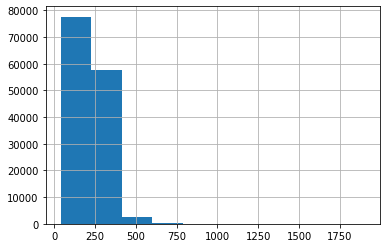

In [30]:
Train_resource["text"].apply(lambda x: len(x.split(" "))).hist()
plt.show()

In [31]:
Train_resource.groupby('domain')['label']\
              .value_counts()

domain                             label   
ACEInhibitors.csv                  negative     2041
                                   positive      166
ADHD.csv                           negative      701
                                   positive       80
Antihistamines.csv                 negative      190
                                   positive       87
Appenzeller-Herzog_2020.csv        negative     2182
                                   positive      161
AtypicalAntipsychotics.csv         negative      670
                                   positive      329
BPA.csv                            negative     6980
                                   positive      101
Bannach-Brown_2019.csv             negative     1347
                                   positive      251
BetaBlockers.csv                   negative     1552
                                   positive      267
CalciumChannelBlockers.csv         negative      824
                                   positive      246
Es

#### Test Resource

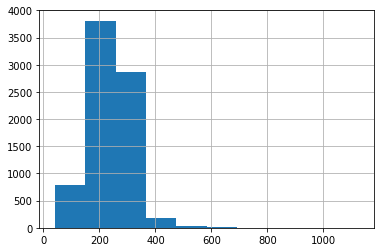

In [32]:
Test_resource["text"].apply(lambda x: len(x.split(" "))).hist()
plt.show()

In [33]:
Test_resource.groupby('domain')['label']\
              .value_counts()

domain                                label   
Distal_radius_fractures_approach.csv  negative     170
                                      positive      10
Hallux_valgus_prognostic.csv          negative     595
                                      positive      19
Head_and_neck_cancer_imaging.csv      negative      38
                                      positive      18
Obstetric_emergency_training.csv      negative     152
                                      positive      18
Pregnancy_medication.csv              negative     337
                                      positive      40
SR11_Li.csv                           negative     200
                                      positive       9
SR12_Cavender.csv                     negative     400
                                      positive      14
SR13_Chatterjee.csv                   negative     400
                                      positive      18
SR14_Funakoshi.csv                    negative    1000
                  

#### Validation Resource

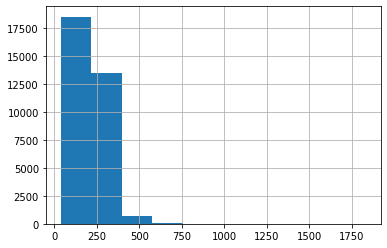

In [34]:
Valid_resource["text"].apply(lambda x: len(x.split(" "))).hist()
plt.show()

In [35]:
Valid_resource.groupby('domain')['label']\
              .value_counts()

domain                                        label   
Bos_2018.csv                                  negative    5593
                                              positive      11
Distal_radius_fractures_closed_reduction.csv  negative     244
                                              positive       6
Fluoride.csv                                  negative    3813
                                              positive      49
Head_and_neck_cancer_bone.csv                 negative     266
                                              positive      32
Kitchenham_2010.csv                           negative    1631
                                              positive      45
Leafy_Greens_Future_set.csv                   positive      62
                                              negative      32
Opiods.csv                                    negative    1675
                                              positive      41
PFOS-PFOA.csv                                 negative    5831


## Meta learning phase

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Meta-Training informations
Info = {
    "inner_print": 2, 
    "bert_layers": 2,
    "tokenizer": initializer_model.tokenizer,
    "max_seq_length": 512,
    "meta_epoch":5, # Outer loop epochs
    "k_spt":8, # Support (training) examples per class, binary case
    "k_qry":8, # Query (testing) examples per class, binary case
    "outer_batch_size": 5, # Size of batch of tasks
    "inner_batch_size": 4, # Size of batch of classifications
    "outer_update_lr" : 5e-5, # Learning rate of task optimizer
    "inner_update_lr" : 5e-5, # Learning rate of classification optimizer
    "inner_update_step" : 4, # Inner loop epochs
    "inner_update_step_eval": 4, # Validation inner loop epochs
    "num_task_train" : 2, # Number of training tasks
    # "num_task_test" : 5 # Number of testing tasks
    "pos_weight" : 3 # p > 1 increases recall, p < 1 increases precision, applied in loss function
}

# SLR classifier model
model = SLR_Classifier(bert_layers = range(Info["bert_layers"]),
                       model = initializer_model.model.bert,
                       drop=0.2)

# Train the model
meta_train(data = Train_resource,
          model = model,
          device = device,
          Info = Info,
          print_epoch =True,
          size_layer=Info["bert_layers"],
          Test_resource=Test_resource)

Meta epoch :   0%|                                        | 0/5 [00:00<?, ?it/s]


-----------------Training Mode Meta_epoch: 0 -----------------

----Task 0 : Wahono_2015.csv ----
Inner Loss:  1.196001946926117
Inner Loss:  1.0354601591825485
----Task 1 : ADHD.csv ----
Inner Loss:  1.1327149718999863
Inner Loss:  0.5819268077611923


f1: 0.7708333432674408
recall: 0.8125


Meta epoch :  20%|██████▍                         | 1/5 [00:17<01:11, 17.82s/it]

Step: 0 	training Acc: 0.75

-----------------Training Mode Meta_epoch: 1 -----------------

----Task 0 : CalciumChannelBlockers.csv ----
Inner Loss:  1.1306694447994232
Inner Loss:  0.8170998394489288
----Task 1 : Antihistamines.csv ----
Inner Loss:  1.1218105405569077
Inner Loss:  0.7896986156702042


f1: 0.6335404217243195
recall: 0.875


Meta epoch :  40%|████████████▊                   | 2/5 [00:22<00:30, 10.20s/it]

Step: 0 	training Acc: 0.5

-----------------Training Mode Meta_epoch: 2 -----------------

----Task 0 : NSAIDS.csv ----
Inner Loss:  1.1956256479024887
Inner Loss:  1.050292730331421
----Task 1 : Leafy_Greens.csv ----
Inner Loss:  1.0169450640678406
Inner Loss:  0.7145338878035545


f1: 0.619047611951828
recall: 0.625


Meta epoch :  60%|███████████████████▏            | 3/5 [00:27<00:15,  7.77s/it]

Step: 0 	training Acc: 0.625

-----------------Training Mode Meta_epoch: 3 -----------------

----Task 0 : Kwok_2020.csv ----
Inner Loss:  1.1574273258447647
Inner Loss:  0.879822388291359
----Task 1 : BetaBlockers.csv ----
Inner Loss:  1.149358093738556
Inner Loss:  0.9481613487005234


f1: 0.3333333432674408
recall: 0.5
Step: 0 	training Acc: 0.5

-----------------Testing Mode-----------------

----Task 0 : SR4_Li.csv ----
Inner Loss:  1.218211591243744
Inner Loss:  1.1553956866264343


f1: 0.6666666865348816
recall: 1.0
----Task 0 : SR8_Liu.csv ----
Inner Loss:  0.908290433883667
Inner Loss:  0.5176807880401612


f1: 0.9473683834075928
recall: 0.8999999761581421
----Task 0 : SR9_Douxfils.csv ----
Inner Loss:  1.009125789006551
Inner Loss:  0.5130249659220377


f1: 0.8235293626785278
recall: 1.0
----Task 0 : SR6_Wang.csv ----
Inner Loss:  0.8053878307342529
Inner Loss:  0.8357309222221374


f1: 0.9523809552192688
recall: 1.0
----Task 0 : SR2_Meng.csv ----
Inner Loss:  1.0176585912704

Meta epoch :  80%|█████████████████████████▌      | 4/5 [01:04<00:19, 19.34s/it]



f1: 0.625
recall: 0.5
Test acc: 0.7284222200512886

-----------------Training Mode Meta_epoch: 4 -----------------

----Task 0 : UrinaryIncontinence.csv ----
Inner Loss:  1.2150991261005402
Inner Loss:  0.9470872730016708
----Task 1 : BPA.csv ----
Inner Loss:  1.0115374475717545
Inner Loss:  0.6384441927075386


f1: 0.761904776096344
recall: 0.75


Meta epoch : 100%|████████████████████████████████| 5/5 [01:09<00:00, 13.82s/it]

Step: 0 	training Acc: 0.75


## Model evaluation

In [ ]:
Valid_resource.groupby('domain')['label'].value_counts()

### Task diagnosis

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

# Initializing model
model_to_finetunning = deepcopy(model)

# Creating validation tasks
valid = MetaTask(Valid_resource,
                 num_task = 500,
                 k_support=10,
                 k_query=20,
                 tokenizer = Info['tokenizer'],
                 training=False)

# Diagnostic dataset
i = valid.task_names =='Opiods.csv'

# Task index
idx = np.array(range(len(i)))[i].item()

# Support (train) e query (test) data
support = valid[idx][0]
query   = valid[idx][1]
name   = valid[idx][2]

print(name)
print(Valid_resource[Valid_resource['domain']== name]['label'].value_counts())
print("k_suport_examples:",len(support))
print("k_query_examples:",len(query))

# Support data loader
support_dataloader = DataLoader(support, sampler=RandomSampler(support),
                                batch_size=5)


#### Untrained model

In [ ]:
model_to_finetunning.to(device)

# Inner Optimizer
inner_optimizer = Adam(model_to_finetunning.parameters(), lr=5e-5)


# Predicting
model_to_finetunning.eval()
with torch.no_grad():
    query_dataloader = DataLoader(query, sampler=None, batch_size=len(query))
    query_batch = iter(query_dataloader).next()
    query_batch = tuple(t.to(device) for t in query_batch)
    q_input_ids, q_attention_mask, q_token_type_ids, q_label_id = query_batch
    
    # Predictions
    _, features, predictions = model_to_finetunning(q_input_ids, q_attention_mask, q_token_type_ids, labels = q_label_id)

    predictions = predictions.detach().cpu().squeeze()
    q_label_id = q_label_id.detach().cpu()

    acc = fn.accuracy(predictions, q_label_id).item()
    print("acc:",acc)

# TSNE Dimensionality reduction
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(features[0].to('cpu'))

# Plot
sns.scatterplot(x=X_embedded[:, 0],
                y=X_embedded[:, 1],
                hue=q_label_id)
plt.show()

#### Trained model

In [ ]:
model_to_finetunning = deepcopy(model)
inner_optimizer = Adam(model_to_finetunning.parameters(), lr=5e-5)
model_to_finetunning.train()
model_to_finetunning.to(device)

# Inner loop training
for i in range(0,Info['inner_update_step']):
    all_loss = []

    # Inner training batch (support set)
    for inner_step, batch in enumerate(support_dataloader):
        
        batch = tuple(t.to("cuda") for t in batch)
        input_ids, attention_mask, token_type_ids, label_id = batch

        # Feed Foward
        loss, _, _ = model_to_finetunning(input_ids, attention_mask, token_type_ids=token_type_ids, labels = label_id)
                      
        loss.backward()
        inner_optimizer.step()
        inner_optimizer.zero_grad()
        
        all_loss.append(loss.item())
    
    if i % Info["inner_print"] == 0:
        print("Inner Loss: ", np.mean(all_loss))

# Predicting
model_to_finetunning.eval()
with torch.no_grad():
    query_dataloader = DataLoader(query, sampler=None, batch_size=len(query))
    query_batch = iter(query_dataloader).next()
    query_batch = tuple(t.to(device) for t in query_batch)
    q_input_ids, q_attention_mask, q_token_type_ids, q_label_id = query_batch
    
    # Predictions
    _, features, predictions = model_to_finetunning(q_input_ids, q_attention_mask, q_token_type_ids, labels = q_label_id)

    predictions = predictions.detach().cpu().squeeze()
    q_label_id = q_label_id.detach().cpu()

    acc = fn.accuracy(predictions, q_label_id).item()
    print("acc:",acc)



model_to_finetunning.to(torch.device('cpu'))
del  inner_optimizer, model_to_finetunning
torch.cuda.empty_cache()


# TSNE Dimensionality reduction
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(features[0].to('cpu'))

# Plot
sns.scatterplot(x=X_embedded[:, 0],
                y=X_embedded[:, 1],
                hue=q_label_id,
                alpha=torch.sigmoid(features[1]).to('cpu').view(-1))
plt.show()

## Domain learning phase
 
Evaluates the model in domain learner phase on the validation resource

In [ ]:
Valid_resource.groupby('domain')['label'].value_counts()

### Tasks diagnosis

In [38]:
# model

# Info = {
#     "inner_print": 1, 
#     "bert_layers": 3,
#     "device": torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
#     # "model": model,
#     "tokenizer": initializer_bert.tokenizer,
#     "max_seq_length": 512,
#     "meta_epoch":30, # Numero de epocas do outerloop
#     "k_spt":20, # Numero de treino por classe (k_spt) caso binario
#     "k_qry":20, # Numero de valicao por classe (k_spt) caso binario
#     "outer_batch_size": 5, # Divide as tasks em batchs tasks
#     "inner_batch_size": 5, # Divide as classificacao em batch de classificao
#     "outer_update_lr" : 5e-5, # Learning rate do otimizador das tasks
#     "inner_update_lr" : 5e-5, # Learning rate do otimizador das classificao
#     "inner_update_step" : 3, # Numero de epocas dentro do inner loop
#     "inner_update_step_eval": 3, # Numero de epocas dentro do inner loop de validacao
#     "num_task_train" : 100, # Quantidade de tarefas de treino
#     "num_task_test" : 5 # Quantidade de tarefas de test
# }

Info['tresh'] = 0.9
Info["inner_update_step_eval"] = 3
Info["inner_print"] = 1

It's possible to access some of the data from the testing dataset after pressing "Train" in the object stantiated by the `diagnosis`, such as:

+ `logits`: logits from classifier stage, no activation

+ `X_embedded`: 2-dimensional values from dimensionality reduction of the latent space

+ `features`: Latent space values  (feature_map layer output)

+ `labels`: True values

+ `data_train`: Training data (Not the same order given to the model on training)

+ `data_test`: Testing data

+ `batch_size_test`: Batch size from the testing dataset, so that prediction time can be reduced

*After press Train Button to perform a domain learning, it's possible evaluate the text used to predict a label by the model in the [Domain Text Avaliation of Positives examples](#another_cell)

Head_and_neck_cancer_bone.csv
-------Train data-------
negative    10
positive    10
Name: label, dtype: int64
-------Test data-------
negative    256
positive     22
Name: label, dtype: int64


Button(description='Next', style=ButtonStyle())

WSS@95:0.3646, R: 0.9545
ASSWSS@95:0.396
Acc.: 0.482
F1-score: 0.2258
Treshold to wss95: 0.5134999752044678

Confusion matrix:
       Predict     
             0    1
Real 0     113  143
     1       1   21

---Metrics with threshold: 0.9 ----

WSS@R:0.0, R: 0.0
AWSS@R:0.0
Acc.: 0.9209
F1-score: 0.0

Confusion matrix:
       Predict   
             0  1
Real 0     256  0
     1      22  0


/usr/local/lib/python3.7/dist-packages/seaborn/relational.py:654: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  kws["alpha"] = 1 if self.alpha == "auto" else self.alpha
/usr/local/lib/python3.7/dist-packages/seaborn/relational.py:654: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  kws["alpha"] = 1 if self.alpha == "auto" else self.alpha


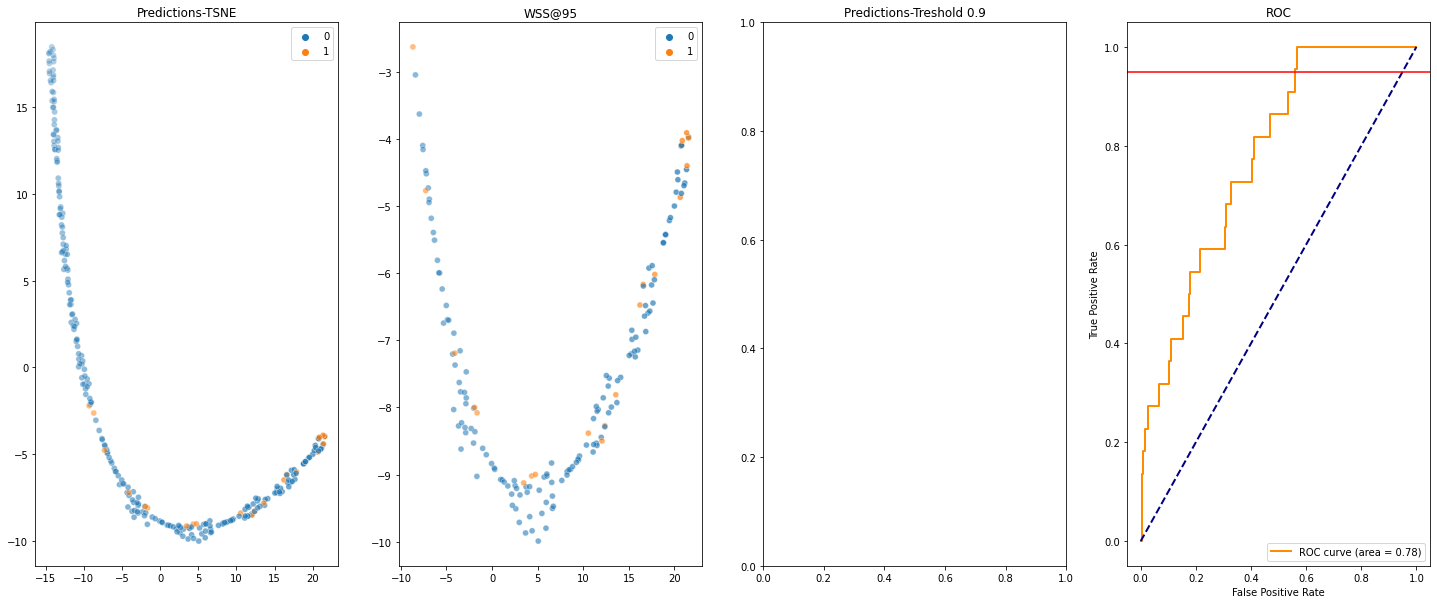

In [39]:
#@title Evaluating validation dataset
batch_size_test =   20 #@param {type:"number"}
# Task names
names = Valid_resource['domain'].unique()

diagnosis5050 = diagnosis(names, Valid_resource, batch_size_test, model, Info, start=0)
diagnosis5050()

### Domain Text Avaliation of Positives examples <a id='Text_avaliation'></a>

In [ ]:
def treat_text(text):
    text = unicodedata.normalize("NFKD",str(text))
    text = multiple_replace(patterns,text.lower())
    text = re.sub('(\(.+\))|(\[.+\])|( \d )|(<)|(>)|(- )','', text)
    text = re.sub('( +)',' ', text)
    text = re.sub('(, ,)|(,,)',',', text)
    text = re.sub('(%)|(per cent)',' percent', text)
    return text

data_test = diagnosis5050.data_test
logits = diagnosis5050.logits

# random choice a positive example
indx= data_test[data_test['label'] == 'positive'].index
indx= np.random.choice(indx)


# print the example
pprint(data_test.iloc[indx])

# Prediction by the model
print("Predicted:",torch.sigmoid(logits[indx]).item() )

# Text of the example
print('Treated Text:')
pprint(treat_text(data_test['text'].iloc[indx]))

# Text of the example
print('Text:')
pprint(treat_text(data_test['text'].iloc[indx]))

## Save model

In [ ]:
import shutil
import datetime
import re
import json
from pathlib import Path

base_path = '5050split'
path_save = "./"+"Models/"+base_path+"/"


# Creating directory
Path(path_save).mkdir(parents=True, exist_ok=True)

# Directory data
check = (str(datetime.datetime.now()))[0:19]
check = re.sub("[:-]","_",check)
check = re.sub(" ","_hr_",check)

print("Data e hora do salvamento:", check)

# Creating directory
Path(f"{path_save}/{check}").mkdir(parents=True, exist_ok=True)

# Saving paths
model_path = f'{path_save}/{check}/model.pt'
meta_info_path = f'{path_save}/{check}/Info.json'

# Meta info
save_info = Info.copy()
save_info['model'] = initializer_model.tokenizer.name_or_path
save_info.pop("tokenizer")

## Saving meta info
with open(meta_info_path, 'w') as fp:
    json.dump(save_info, fp)

## Saving entire model
torch.save(model, model_path)

# To save only parameters:
# torch.save(model.state_dict(), model_path)

## Load model

In [ ]:
# Downloading entire model
model = torch.load(model_path)
model

## Computing simulation attemps

5 attemps in the domain learner phase with the validation resource is computed to evaluate the performance of the model.

In [ ]:
names_to_valid = Valid_resource['domain'].unique()

In [ ]:
torch.clear_autocast_cache()
gc.collect()
torch.cuda.empty_cache()

base_path = '5050split'
path_save = "./"+"Results/"+base_path+"/"

pipeline_simulation(Valid_resource, names_to_valid, path_save, model, Info)

# Comparison simulation

This section explore the methodology of train the ML-SLRC with the remain dataset that don't correspond the Benchmarks datasets, [SWIFT](https://pubmed.ncbi.nlm.nih.gov/27216467/) and [cohen Drugs Review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1447545/) to peform a comparison of WSS@95 in the ([Kusa at al., 2022](https://arxiv.org/abs/2201.07534)).


### Directory creation

In [ ]:
import glob
import os

path = 'SLR_data'

cohen_paths = glob.glob(f"{path}/**/cohen/*.csv", recursive=True)
SWIFT_paths = glob.glob(f"{path}/**/SWIFT systematic review data/*.csv", recursive=True)

cohen_names = [os.path.basename(p) for p in cohen_paths]
SWIFT_names = [os.path.basename(p) for p in SWIFT_paths]

base_path = 'Comparison'

#### Data split

In [ ]:
from itertools import chain

All_data = load_data(
    info_load
)

All_data = All_data.dropna().reset_index().drop("index", axis=1)

comparison_names = list(chain.from_iterable([cohen_names, SWIFT_names]))

cohen_data = All_data[All_data['domain'].isin(cohen_names)]
cohen_data =  cohen_data.reset_index().drop("index", axis=1)

SWIFT_data = All_data[All_data['domain'].isin(SWIFT_names)]
SWIFT_data =  SWIFT_data.reset_index().drop("index", axis=1)

Train_resource = All_data[~All_data['domain'].isin(comparison_names)]
Train_resource =  Train_resource.reset_index().drop("index", axis=1)

In [ ]:
# Selecting data with at least 40 words separated by spaces
crit = Train_resource["text"].apply(lambda x: len(x.split(" "))) >= 40
Train_resource = Train_resource[crit].reset_index().drop("index", axis=1)

### Exploratory Data Analysis

Histograms of number of words separated by " " and count of positive and negative examples of each dataset of the resource

#### Train Resource



In [ ]:
Train_resource["text"].apply(lambda x: len(x.split(" "))).hist()
plt.show()

In [ ]:
Train_resource.groupby('domain')['label']\
              .value_counts()

#### cohen Dataset

In [ ]:
cohen_data["text"].apply(lambda x: len(x.split(" "))).hist()
plt.show()

In [ ]:
cohen_data.groupby('domain')['label']\
              .value_counts()

#### SWIFT Dataset

In [ ]:
SWIFT_data["text"].apply(lambda x: len(x.split(" "))).hist()
plt.show()

In [ ]:
SWIFT_data.groupby('domain')['label']\
              .value_counts()

## Meta learning phase

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Meta-Training informations
Info = {
    "inner_print": 2, 
    "bert_layers": 2,
    "tokenizer": initializer_model.tokenizer,
    "max_seq_length": 512,
    "meta_epoch":5, # Outer loop epochs
    "k_spt":8, # Support (training) examples per class, binary case
    "k_qry":8, # Query (testing) examples per class, binary case
    "outer_batch_size": 5, # Size of batch of tasks
    "inner_batch_size": 4, # Size of batch of classifications
    "outer_update_lr" : 5e-5, # Learning rate of task optimizer
    "inner_update_lr" : 5e-5, # Learning rate of classification optimizer
    "inner_update_step" : 4, # Inner loop epochs
    "inner_update_step_eval": 4, # Validation inner loop epochs
    "num_task_train" : 2, # Number of training tasks
    # "num_task_test" : 5 # Number of testing tasks
    "pos_weight" : 3 # p > 1 increases recall, p < 1 increases precision, applied in loss function
}

model = SLR_Classifier(bert_layers = range(Info["bert_layers"]),
                       model = initializer_model.model.bert,
                       drop=0.2)


meta_train(data = Train_resource,
          model = model,
          device = device,
          Info = Info,
          print_epoch =True,
          size_layer=Info["bert_layers"],
          Test_resource=None)

## Model evaluation

In [ ]:
SWIFT_data.groupby('domain')['label'].value_counts()

### Task diagnosis

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

# Initializing model
model_to_finetunning = deepcopy(model)

# Creating validation tasks
valid = MetaTask(SWIFT_data,
                 num_task = 500,
                 k_support=10,
                 k_query=20,
                 tokenizer = Info['tokenizer'],
                 training=False)

# Diagnostic dataset
i = valid.task_names =='Neuropain.csv'

# Task index
idx = np.array(range(len(i)))[i].item()

# Support (train) e query (test) data
support = valid[idx][0]
query   = valid[idx][1]
name   = valid[idx][2]

print(name)
print(SWIFT_data[SWIFT_data['domain']== name]['label'].value_counts())
print("k_suport_examples:",len(support))
print("k_query_examples:",len(query))

# Support data loader
support_dataloader = DataLoader(support, sampler=RandomSampler(support),
                                batch_size=5)


#### Untrained model

In [ ]:
model_to_finetunning.to(device)

# Inner Optimizer
inner_optimizer = Adam(model_to_finetunning.parameters(), lr=5e-5)


# Predicting
model_to_finetunning.eval()
with torch.no_grad():
    query_dataloader = DataLoader(query, sampler=None, batch_size=len(query))
    query_batch = iter(query_dataloader).next()
    query_batch = tuple(t.to(device) for t in query_batch)
    q_input_ids, q_attention_mask, q_token_type_ids, q_label_id = query_batch
    
    # Predictions
    _, features, predictions = model_to_finetunning(q_input_ids, q_attention_mask, q_token_type_ids, labels = q_label_id)

    predictions = predictions.detach().cpu().squeeze()
    q_label_id = q_label_id.detach().cpu()

    acc = fn.accuracy(predictions, q_label_id).item()
    print("acc:",acc)

# TSNE Dimensionality reduction
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(features[0].to('cpu'))

# Plot
sns.scatterplot(x=X_embedded[:, 0],
                y=X_embedded[:, 1],
                hue=q_label_id)
plt.show()

#### Trained model

In [ ]:
model_to_finetunning = deepcopy(model)
inner_optimizer = Adam(model_to_finetunning.parameters(), lr=5e-5)
model_to_finetunning.train()
model_to_finetunning.to(device)

# Inner loop training
for i in range(0,Info['inner_update_step']):
    all_loss = []

    # Inner training batch (support set)
    for inner_step, batch in enumerate(support_dataloader):
        
        batch = tuple(t.to("cuda") for t in batch)
        input_ids, attention_mask, token_type_ids, label_id = batch

        # Feed Foward
        loss, _, _ = model_to_finetunning(input_ids, attention_mask, token_type_ids=token_type_ids, labels = label_id)
                      
        loss.backward()
        inner_optimizer.step()
        inner_optimizer.zero_grad()
        
        all_loss.append(loss.item())
    
    if i % Info["inner_print"] == 0:
        print("Inner Loss: ", np.mean(all_loss))

# Predicting
model_to_finetunning.eval()
with torch.no_grad():
    query_dataloader = DataLoader(query, sampler=None, batch_size=len(query))
    query_batch = iter(query_dataloader).next()
    query_batch = tuple(t.to(device) for t in query_batch)
    q_input_ids, q_attention_mask, q_token_type_ids, q_label_id = query_batch
    
    # Predictions
    _, features, predictions = model_to_finetunning(q_input_ids, q_attention_mask, q_token_type_ids, labels = q_label_id)

    predictions = predictions.detach().cpu().squeeze()
    q_label_id = q_label_id.detach().cpu()

    acc = fn.accuracy(predictions, q_label_id).item()
    print("acc:",acc)



model_to_finetunning.to(torch.device('cpu'))
del  inner_optimizer, model_to_finetunning
torch.cuda.empty_cache()


# TSNE Dimensionality reduction
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(features[0].to('cpu'))

# Plot
sns.scatterplot(x=X_embedded[:, 0],
                y=X_embedded[:, 1],
                hue=q_label_id,
                alpha=torch.sigmoid(features[1]).to('cpu').view(-1))
plt.show()

## Domain learning phase on SWIFT datasets

In [ ]:
SWIFT_data.groupby('domain')['label'].value_counts()

### Diagnosis

In [ ]:
# model

# Info = {
#     "inner_print": 1, 
#     "bert_layers": 3,
#     "device": torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
#     # "model": model,
#     "tokenizer": initializer_bert.tokenizer,
#     "max_seq_length": 512,
#     "meta_epoch":30, # Numero de epocas do outerloop
#     "k_spt":20, # Numero de treino por classe (k_spt) caso binario
#     "k_qry":20, # Numero de valicao por classe (k_spt) caso binario
#     "outer_batch_size": 5, # Divide as tasks em batchs tasks
#     "inner_batch_size": 5, # Divide as classificacao em batch de classificao
#     "outer_update_lr" : 5e-5, # Learning rate do otimizador das tasks
#     "inner_update_lr" : 5e-5, # Learning rate do otimizador das classificao
#     "inner_update_step" : 3, # Numero de epocas dentro do inner loop
#     "inner_update_step_eval": 3, # Numero de epocas dentro do inner loop de validacao
#     "num_task_train" : 100, # Quantidade de tarefas de treino
#     "num_task_test" : 5 # Quantidade de tarefas de test
# }

Info['tresh'] = 0.9
Info["inner_update_step_eval"] = 3
Info["inner_print"] = 1

It's possible to access some of the data from the testing dataset after pressing "Train" in the object stantiated by the `diagnosis`, such as:

+ `logits`: logits from classifier stage, no activation

+ `X_embedded`: 2-dimensional values from dimensionality reduction of the latent space

+ `features`: Latent space values  (feature_map layer output)

+ `labels`: True values

+ `data_train`: Training data (Not the same order given to the model on training)

+ `data_test`: Testing data

+ `batch_size_test`: Batch size from the testing dataset, so that prediction time can be reduced

*After press Train Button to perform a domain learning, it's possible evaluate the text used to predict a label by the model in the [Domain Text Avaliation of Positives examples](#Text_avaliation_2)

In [ ]:
#@title Evaluating validation dataset
batch_size_test =   20 #@param {type:"number"}
# Task names
names = SWIFT_data['domain'].unique()

diagnosis_comp = diagnosis(names, SWIFT_data, batch_size_test, model,Info, start=0)
diagnosis_comp()

### Text Avaliation of Positives examples <a id='Text_avaliation_2'></a>

In [ ]:
def treat_text(text):
    text = unicodedata.normalize("NFKD",str(text))
    text = multiple_replace(patterns,text.lower())
    text = re.sub('(\(.+\))|(\[.+\])|( \d )|(<)|(>)|(- )','', text)
    text = re.sub('( +)',' ', text)
    text = re.sub('(, ,)|(,,)',',', text)
    text = re.sub('(%)|(per cent)',' percent', text)
    return text

data_test = diagnosis_comp.data_test
logits = diagnosis_comp.logits

# random choice a positive example
indx= data_test[data_test['label'] == 'positive'].index
indx= np.random.choice(indx)


# print the example
pprint(data_test.iloc[indx])

# Prediction by the model
print("Predicted:",torch.sigmoid(logits[indx]).item() )

# Text of the example
print('Treated Text:')
pprint(treat_text(data_test['text'].iloc[indx]))

# Text of the example
print('Text:')
pprint(treat_text(data_test['text'].iloc[indx]))

## Save model

In [ ]:
import shutil
import datetime
import re
import json
from pathlib import Path

base_path = 'Comparison'
path_save = "./"+"Models/"+base_path+"/"



# Creating directory
Path(path_save).mkdir(parents=True, exist_ok=True)

# Directory data
check = (str(datetime.datetime.now()))[0:19]
check = re.sub("[:-]","_",check)
check = re.sub(" ","_hr_",check)

print("Data e hora do salvamento:", check)

# Creating directory
Path(f"{path_save}/{check}").mkdir(parents=True, exist_ok=True)

# Saving paths
model_path = f'{path_save}/{check}/model.pt'
meta_info_path = f'{path_save}/{check}/Info.json'

# Meta info
save_info = Info.copy()
save_info['model'] = initializer_model.tokenizer.name_or_path
save_info.pop("tokenizer")

## Saving meta info
with open(meta_info_path, 'w') as fp:
    json.dump(save_info, fp)

## Saving entire model
torch.save(model, model_path)

# To save only parameters:
# torch.save(model.state_dict(), model_path)

## Load model

In [ ]:
# Downloading entire model
model = torch.load(model_path)
model

## Computing simulation attemps on SWIFT datasets

In [ ]:
torch.clear_autocast_cache()
gc.collect()
torch.cuda.empty_cache()

path_save = "./"+"Results/"+base_path+"/SWIFT/"

pipeline_simulation(SWIFT_data, SWIFT_names, path_save, model, Info)

## Computing simulation attemps on cohen datasets

In [ ]:
torch.clear_autocast_cache()
gc.collect()
torch.cuda.empty_cache()

path_save = "./"+"Results/"+base_path+"/Drugs/"

pipeline_simulation(cohen_data, cohen_names, path_save, model, Info)